# Descripción del problema - Differential Evolution Version

*Differential Evolution (DE)* is a vector-based metaheuristic algorithm that has good convergence properties. There are many DE variants, and they have been applied in a wide range of disciplines. This chapter provides a brief introduction to the basic differential evolution and its main implementation details and variants. Fundamental convergence properties in terms of population variance are also discussed.

# Código - Búsqueda de rutas del metro

p.163 de Algoritmos Evolutivos

In [ ]:
!pip install networkx pandas ipywidgets matplotlib

In [ ]:
import random
import math
import io
import time # <<< Importar módulo time
from collections import defaultdict, deque
from typing import List, Tuple, Dict, Set
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import re
from collections import defaultdict
from google.colab import drive

# --- FUNCIONES DE PARSEO Y GRAFO (Sin cambios) ---

def parse_metro_file(text: str):
    """
    Devuelve:
      - lines_dict: {line_name: [station1, station2, ...]}
      - station_lines: {station_name: set(line_names)}  (estaciones con correspondencias)
    """
    lines_dict = {}
    station_lines = defaultdict(set)
    cur_line = None

    for raw in text.splitlines():
        line = raw.strip()
        if not line:
            continue
        if line == "#":
            cur_line = None
            continue
        if line.startswith("Linea"):
            cur_line = line
            lines_dict[cur_line] = []
            continue

        if cur_line is None:
            continue

        # Extraer nombre de estación y líneas de correspondencia dentro de paréntesis
        match = re.match(r'([^\*]+)\s*\*\s*(\(([^)]+)\))?', line)
        if not match:
            continue
        station_name = match.group(1).strip().replace(" ", "_")
        corres_lines = []
        if match.group(3):
            corres_lines = [l.strip() for l in match.group(3).split(",")]

        # Guardar en dicts
        lines_dict[cur_line].append(station_name)
        station_lines[station_name].add(cur_line)
        for l in corres_lines:
            station_lines[station_name].add(l)

    return lines_dict, dict((k, set(v)) for k, v in station_lines.items())

def build_graph(lines_dict: Dict[str, List[str]], station_lines: Dict[str, Set[str]],
                equivalent_pairs: List[Tuple[str,str]] = None):
    G = nx.Graph()
    # nodos
    for station, lines in station_lines.items():
        G.add_node(station, lines=set(lines))
    # aristas por continuidad de línea
    for line, stations in lines_dict.items():
        for i in range(len(stations)-1):
            a, b = stations[i], stations[i+1]
            if not G.has_node(a):
                G.add_node(a, lines=set([line]))
            if not G.has_node(b):
                G.add_node(b, lines=set([line]))
            G.add_edge(a, b, type='line', lines=set([line]), weight=1.0)
    # aristas de correspondencia
    if equivalent_pairs:
        for a,b in equivalent_pairs:
            if not G.has_node(a):
                G.add_node(a, lines=set())
            if not G.has_node(b):
                G.add_node(b, lines=set())
            G.add_edge(a,b, type='transfer', lines=set(), weight=0.5)  # transfer ligero
    return G

# --- FUNCIONES DE INDIVIDUO Y REPRESENTACIÓN (Sin cambios) ---

def random_walk_path(G: nx.Graph, start: str, goal: str, max_len: int, avoid: Set[str]=None):
    if avoid is None:
        avoid = set()
    for attempt in range(200):
        path = [start]
        visited = set([start])
        cur = start
        steps = 0
        while cur != goal and steps < max_len:
            neighbors = [n for n in G.neighbors(cur) if n not in visited and n not in avoid]
            if not neighbors:
                break
            cur = random.choice(neighbors)
            path.append(cur)
            visited.add(cur)
            steps += 1
        if path[-1] == goal:
            return path
    return None

def generate_initial_population(G, start, goal, pop_size, max_ind_len, avoid):
    population = []
    for _ in range(pop_size):
        p = random_walk_path(G, start, goal, max_ind_len, avoid)
        if p is None:
            try:
                sp = nx.shortest_path(G, start, goal)
                if len(sp) <= max_ind_len:
                    p = sp
                else:
                    p = sp[:max_ind_len]
            except Exception:
                p = [start]
                cur = start
                for _ in range(min(3, max_ind_len-1)):
                    nbrs = list(G.neighbors(cur))
                    if not nbrs: break
                    cur = random.choice(nbrs)
                    p.append(cur)
                if p[-1] != goal:
                    p.append(goal)
        seen = set()
        cleaned = []
        for s in p:
            if s not in seen:
                cleaned.append(s)
                seen.add(s)
        population.append(cleaned)
    return population

def repair_path_connectivity(path: List[str], G: nx.Graph, max_hop=20):
    newp = [path[0]]
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        if G.has_edge(u,v) or v in G[u]:
            newp.append(v)
            continue
        try:
            sp = nx.shortest_path(G, u, v)
            for node in sp[1:]:
                if node not in newp:
                    newp.append(node)
        except Exception:
            if v not in newp:
                newp.append(v)
    final = []
    seen = set()
    for s in newp:
        if s not in seen:
            final.append(s)
            seen.add(s)
    return final

# --- OPERADORES (Usados por GA y adaptados para DE) ---

def crossover_one(a: List[str], b: List[str], start, goal, G):
    """Cruce: busca punto común o hace segment swap."""
    common = set(a[1:-1]).intersection(set(b[1:-1]))
    if common:
        mid = random.choice(list(common))
        ai = a.index(mid)
        bi = b.index(mid)
        child = a[:ai] + b[bi:]
    else:
        if len(a) < 3 or len(b) < 3:
            child = a[:] if len(a) >= len(b) else b[:]
        else:
            ca = random.randint(1, max(1, len(a)-2))
            cb = random.randint(1, max(1, len(b)-2))
            child = a[:ca] + b[cb:]
    # reparar duplicados
    seen = set()
    repaired = []
    for s in child:
        if s not in seen:
            repaired.append(s)
            seen.add(s)
    if repaired[0] != start:
        repaired.insert(0, start)
    if repaired[-1] != goal:
        repaired.append(goal)
    repaired = repair_path_connectivity(repaired, G, max_hop=8)
    return repaired

def mutate_one(path: List[str], G, max_len, avoid=set()):
    """Mutación: insertar, eliminar o re-cablear subcamino."""
    p = path[:]
    op = random.choice(['insert', 'delete', 'swap', 'rewire'])
    if op == 'insert' and len(p) < max_len:
        i = random.randint(0, max(0, len(p)-2))
        u, v = p[i], p[i+1]
        rw = random_walk_path(G, u, v, max_len=6, avoid=avoid)
        if rw and len(rw) > 2:
            for node in rw[1:-1]:
                if node not in p:
                    p.insert(i+1, node)
                    i += 1
    elif op == 'delete' and len(p) > 3:
        i = random.randint(1, len(p)-2)
        del p[i]
    elif op == 'swap' and len(p) > 3:
        i = random.randint(1, len(p)-2)
        j = random.randint(1, len(p)-2)
        p[i], p[j] = p[j], p[i]
    elif op == 'rewire' and len(p) > 2:
        i = random.randint(0, len(p)-2)
        u, v = p[i], p[-1]
        rw = random_walk_path(G, u, v, max_len=8, avoid=avoid)
        if rw:
            p = p[:i] + rw
    p = repair_path_connectivity(p, G)
    if len(p) > max_len:
        p = p[:max_len-1] + [p[-1]]
    return p

# --- FUNCIÓN DE APTITUD (FITNESS) (Sin cambios) ---

def count_transfers_and_lines(path: List[str], G: nx.Graph):
    line_sequence = []
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        edge_data = G.get_edge_data(u, v, default={})
        lines_edge = set()
        if 'lines' in edge_data and edge_data['lines']:
            lines_edge = set(edge_data['lines'])
        inter = set(G.nodes[u].get('lines', set())).intersection(set(G.nodes[v].get('lines', set())))
        if inter:
            chosen = next(iter(inter))
        elif lines_edge:
            chosen = next(iter(lines_edge))
        else:
            lu = G.nodes[u].get('lines', set())
            chosen = next(iter(lu)) if lu else "Unknown"
        line_sequence.append(chosen)
    transfers = sum(1 for i in range(len(line_sequence)-1) if line_sequence[i] != line_sequence[i+1])
    node_lines = []
    if line_sequence:
        node_lines.append(line_sequence[0])
        for l in line_sequence[1:]:
            node_lines.append(l)
        node_lines.append(node_lines[-1])
    else:
        node_lines = ["Unknown"] * len(path)
    return transfers, node_lines

def fitness_of(path: List[str], G: nx.Graph, required: Set[str], forbidden: Set[str],
               w_length=1.0, w_transfers=1.0, w_required=10.0, w_forbidden=10.0, w_repeat=100.0):
    length = len(path)
    transfers, node_lines = count_transfers_and_lines(path, G)
    missing_required = len([r for r in required if r not in path])
    forbidden_present = len([f for f in forbidden if f in path])
    repeats = len(path) - len(set(path))
    disconnected = 0
    for i in range(len(path)-1):
        if not G.has_edge(path[i], path[i+1]):
            disconnected += 1
    # compose fitness (lower is better)
    score = (w_length * length) + (w_transfers * transfers) + (w_required * missing_required) + \
            (w_forbidden * forbidden_present) + (w_repeat * repeats) + (w_repeat * disconnected * 2)
    return score, {
        'length': length,
        'transfers': transfers,
        'missing_required': missing_required,
        'forbidden_present': forbidden_present,
        'repeats': repeats,
        'disconnected': disconnected,
        'node_lines': node_lines
    }

# --- NÚCLEO DE EVOLUCIÓN DIFERENCIAL (DE) ---

def de_mutation_crossover(pop: List[List[str]], G: nx.Graph, start: str, goal: str, max_ind_len: int, forbidden: Set[str], F: float, CR: float):
    """
    Simula la mutación (diferencial) y el cruce de DE en individuos (caminos) discretos.
    Utiliza operadores de cruce y mutación adaptados para caminos.
    """
    newpop = []
    pop_size = len(pop)

    for i in range(pop_size):
        x_i = pop[i]

        # 1. Mutación (Creación del Vector Donante 'v'): Estrategia adaptada DE/rand/1/bin
        indices = list(range(pop_size))
        indices.remove(i)

        if len(indices) < 3:
            r1, r2, r3 = random.choices(indices, k=3) if indices else (0, 0, 0)
        else:
            r1, r2, r3 = random.sample(indices, 3)

        x_r1, x_r2, x_r3 = pop[r1], pop[r2], pop[r3]

        # Simulación de la diferencia y suma vectoriales:
        if random.random() < F:
            diff_vector = crossover_one(x_r2, x_r3, start, goal, G)
        else:
            diff_vector = x_r2[:]

        v_i = crossover_one(x_r1, diff_vector, start, goal, G)

        # 2. Cruce (Creación del Vector de Prueba 'u')
        if random.random() < CR:
            u_i = crossover_one(x_i, v_i, start, goal, G)
        else:
            u_i = x_i[:]

        # Mutación local: asegurar cierta diversidad adicional (opcional, p_mut baja)
        if random.random() < 0.1:
             u_i = mutate_one(u_i, G, max_ind_len, avoid=forbidden)

        # Post-proceso y aseguramiento de límites
        if len(u_i) > max_ind_len:
            u_i = u_i[:max_ind_len-1] + [goal]
        if u_i[0] != start:
             u_i.insert(0, start)
        if u_i[-1] != goal:
             u_i.append(goal)

        newpop.append(u_i)

    return newpop

def run_evolution_de(G, start, goal, required=set(), forbidden=set(),
                     pop_size=100, iterations=200, F=0.5, CR=0.8, max_ind_len=40,
                     w_length=1.0, w_transfers=1.5, w_required=20.0, w_forbidden=50.0, seed=None,
                     verbose=False):
    """
    Ejecuta el Algoritmo de Evolución Diferencial (DE) y retorna el tiempo de ejecución.
    """

    start_time = time.time() # <<< Inicio del contador de tiempo

    if seed is not None:
        random.seed(seed)

    pop = generate_initial_population(G, start, goal, pop_size, max_ind_len, forbidden)

    best_overall = None
    best_score = float('inf')
    best_diag = None

    for it in range(iterations):
        # 1. Calcular fitness de la población actual (x_i)
        current_fitnesses = []
        current_diags = []
        for ind in pop:
            score, diag = fitness_of(ind, G, required, forbidden, w_length, w_transfers, w_required, w_forbidden, w_repeat=100.0)
            current_fitnesses.append(score)
            current_diags.append(diag)
            if score < best_score:
                best_score = score
                best_overall = ind[:]
                best_diag = diag

        # 2. Mutación y Cruce de DE (Crear población de prueba/trial)
        trial_pop = de_mutation_crossover(pop, G, start, goal, max_ind_len, forbidden, F, CR)

        # 3. Selección Codiciosa (entre x_i y u_i)
        next_pop = []
        for i in range(pop_size):
            x_i = pop[i]
            u_i = trial_pop[i]

            # Calcular fitness del individuo de prueba (u_i)
            u_i_score, u_i_diag = fitness_of(u_i, G, required, forbidden,
                                             w_length, w_transfers, w_required, w_forbidden, w_repeat=100.0)

            # Selección Codiciosa
            if u_i_score < current_fitnesses[i]:
                next_pop.append(u_i)
                if u_i_score < best_score:
                    best_score = u_i_score
                    best_overall = u_i[:]
                    best_diag = u_i_diag
            else:
                next_pop.append(x_i)

        pop = next_pop

        if verbose and it % max(10, iterations//10) == 0:
            print(f"Iter {it} best {best_score} len {len(best_overall)}")

    end_time = time.time() # <<< Fin del contador de tiempo
    elapsed_time = end_time - start_time # <<< Cálculo del tiempo transcurrido

    return best_overall, best_score, best_diag, elapsed_time # <<< Retorna el tiempo

# --- FUNCIÓN DE TABLA Y UI (Modificada para mostrar el tiempo) ---

def path_to_table(path: List[str], node_lines: List[str], G: nx.Graph):
    rows = []
    for i in range(len(path)-1):
        s_from = path[i]
        s_to = path[i+1]
        line_from = node_lines[i] if i < len(node_lines) else "?"
        line_to = node_lines[i+1] if (i+1) < len(node_lines) else line_from
        action = ""
        if line_from != line_to:
            action = f"Transbordo a {line_to}"
        else:
            action = "Seguir"
        rows.append({
            "Linea origen": line_from,
            "Estacion origen": s_from,
            "Linea destino": line_to,
            "Estacion destino": s_to,
            "Accion": action
        })
    df = pd.DataFrame(rows)
    return df

def create_ui_and_run(
    metro_text,
    parse_metro_file,
    build_graph,
    run_evolution_de,
    count_transfers_and_lines,
    path_to_table
):
    lines_dict, station_lines = parse_metro_file(metro_text)
    all_stations = sorted([s.replace(" ", "_") for s in station_lines.keys()])

    # Inputs de origen y destino
    start_input = widgets.Combobox(
        value='', placeholder='Selecciona origen', options=all_stations, description='Origen:'
    )
    goal_input = widgets.Combobox(
        value='', placeholder='Selecciona destino', options=all_stations, description='Destino:'
    )

    # Campos autocompletables para obligatorias y prohibidas
    req_inputs = []
    forb_inputs = []
    req_box = widgets.VBox()
    forb_box = widgets.VBox()

    def add_req_field(_=None):
        cb = widgets.Combobox(placeholder='Estación obligatoria', options=all_stations)
        req_inputs.append(cb)
        req_box.children = req_inputs

    def add_forb_field(_=None):
        cb = widgets.Combobox(placeholder='Estación prohibida', options=all_stations)
        forb_inputs.append(cb)
        forb_box.children = forb_inputs

    add_req_btn = widgets.Button(description="Agregar obligatoria", button_style='info')
    add_forb_btn = widgets.Button(description="Agregar prohibida", button_style='info')
    add_req_btn.on_click(add_req_field)
    add_forb_btn.on_click(add_forb_field)

    # Sliders de Evolución Diferencial
    pop_slider = widgets.IntSlider(value=250, min=10, max=400, step=10, description="Población:")
    iter_slider = widgets.IntSlider(value=250, min=10, max=2000, step=10, description="Iteraciones:")
    F_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description="Factor F (Mutación):")
    CR_slider = widgets.FloatSlider(value=0.8, min=0.0, max=1.0, step=0.01, description="Tasa CR (Cruce):")
    max_ind = widgets.IntSlider(value=200, min=10, max=200, step=1, description="Tam max indiv:")

    # Pesos de Fitness
    w_len = widgets.FloatText(value=1.0, description="Peso length:")
    w_trans = widgets.FloatText(value=3, description="Peso transbordos:")
    w_req = widgets.FloatText(value=20.0, description="Peso falt. oblig.:")
    w_forb = widgets.FloatText(value=20.0, description="Peso prohibidas:")
    run_button = widgets.Button(description="Calcular ruta (Evolución Diferencial)", button_style='success', icon='check')
    output = widgets.Output(layout={'border': '1px solid black'})

    # UI general
    ui = widgets.VBox([
        widgets.HBox([start_input, goal_input]),
        widgets.HTML("<b>Estaciones obligatorias</b>"),
        req_box, add_req_btn,
        widgets.HTML("<b>Estaciones prohibidas</b>"),
        forb_box, add_forb_btn,
        pop_slider, iter_slider, F_slider, CR_slider, max_ind,
        widgets.HBox([w_len, w_trans]),
        widgets.HBox([w_req, w_forb]),
        run_button,
        output
    ])
    display(ui)

    # Función principal
    def on_run_clicked(b):
        with output:
            clear_output()
            start = start_input.value.strip().replace(" ", "_")
            goal = goal_input.value.strip().replace(" ", "_")

            required = {cb.value.strip() for cb in req_inputs if cb.value}
            forbidden = {cb.value.strip() for cb in forb_inputs if cb.value}

            G = build_graph(lines_dict, station_lines)

            if start not in G.nodes or goal not in G.nodes:
                print("⚠️ Origen o destino inválido.")
                return

            print("Ejecutando algoritmo de Evolución Diferencial...")

            # 🌟 Llamada a la función DE 🌟
            best_path, best_score, diag, elapsed_time = run_evolution_de(
                G,
                start=start,
                goal=goal,
                required=required,
                forbidden=forbidden,
                pop_size=pop_slider.value,
                iterations=iter_slider.value,
                F=F_slider.value,
                CR=CR_slider.value,
                max_ind_len=max_ind.value,
                w_length=w_len.value,
                w_transfers=w_trans.value,
                w_required=w_req.value,
                w_forbidden=w_forb.value,
                seed=42,
                verbose=True
            )

            if best_path is None:
                print("No se encontró ruta válida.")
                return

            # 🌟 Muestra el tiempo de ejecución 🌟
            print(f"\n✅ Tiempo de ejecución: **{elapsed_time:.4f} segundos**")
            print(f"Mejor score: {best_score}")
            print("\nRuta encontrada (estación [línea]):")

            transfers, node_lines = count_transfers_and_lines(best_path, G)
            for s, l in zip(best_path, node_lines):
                print(f" - {s} [{l}]")

            df = path_to_table(best_path, node_lines, G)
            display(df)

            line_colors = {
                "Linea_1N": "deepskyblue", "Linea_2": "red", "Linea_3": "yellow",
                "Linea_4": "saddlebrown", "Linea_5": "lightgreen", "Linea_6": "gray",
                "Linea_7": "orange", "Linea_8": "pink", "Linea_9": "purple",
                "Linea_10": "blue", "Linea_11": "green", "Linea_12": "gold",
                "Linea_Ramal": "white"
            }

            try:
                colors = [line_colors.get(l, "black") for l in node_lines]
                plt.figure(figsize=(10,6))
                subG = G.subgraph(best_path)
                pos = nx.spring_layout(subG, seed=42)
                nx.draw_networkx_nodes(subG, pos, node_size=200, node_color=colors)
                nx.draw_networkx_labels(subG, pos, font_size=8)
                nx.draw_networkx_edges(subG, pos, width=2)
                plt.title("Subgrafo del recorrido (colores por línea)")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print("Error al dibujar grafo:", e)

    run_button.on_click(on_run_clicked)

# --- EJECUCIÓN DEL PROGRAMA ---

# 1️⃣ Monta tu Google Drive
drive.mount('/content/drive') # Descomenta si es necesario

# 2️⃣ Define la ruta exacta a tu archivo .txt
# 👇 CAMBIA ESTA RUTA por la ubicación real en tu Drive
ruta_archivo = '/content/drive/MyDrive/Cuatri 1/Said/lineas_metro_madrid.txt'

# 3️⃣ Lee el contenido del archivo
try:
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        example_small = f.read()
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en la ruta: {ruta_archivo}")
    print("Asegúrate de que la ruta sea correcta y Google Drive esté montado.")
    example_small = ""

# 4️⃣ Ejecuta la UI usando la versión de Evolución Diferencial (DE)
if example_small:
    create_ui_and_run(
        example_small,
        parse_metro_file,
        build_graph,
        run_evolution_de,
        count_transfers_and_lines,
        path_to_table
    )

Mounted at /content/drive


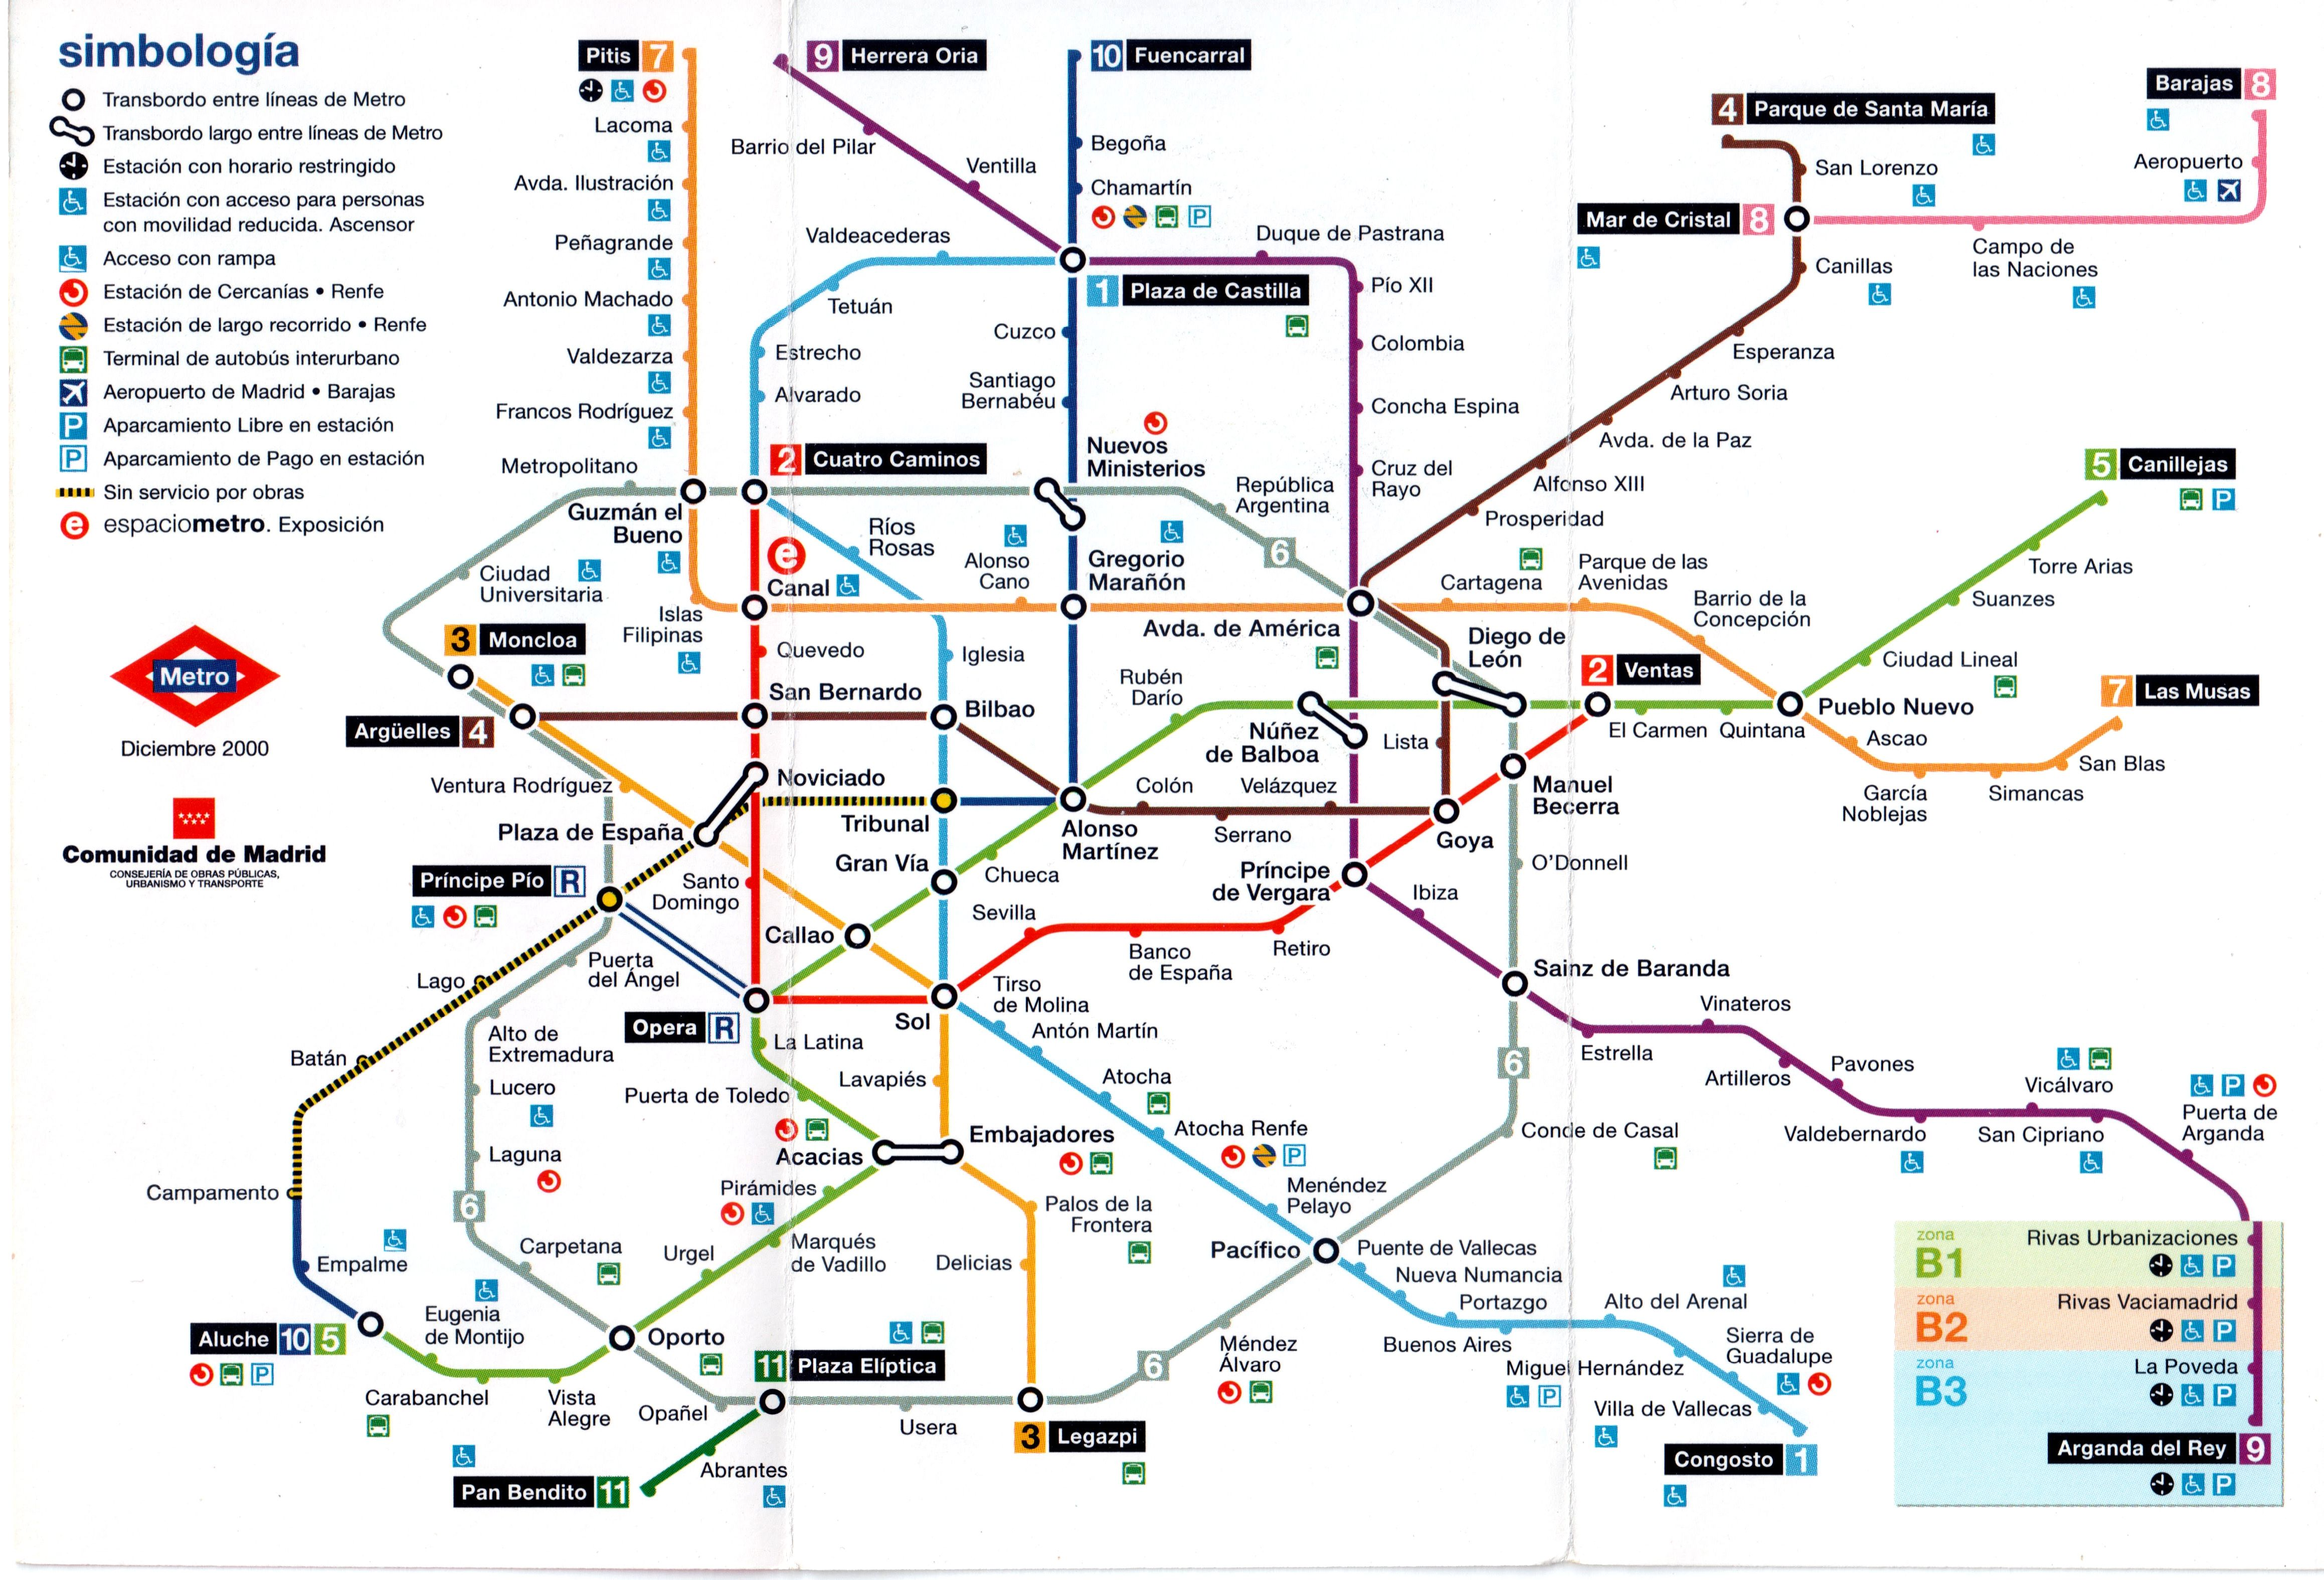